# Precision loss due to float32 conversion with ONNX

The notebook studies the loss of precision while converting a non-continuous model into float32. It studies the conversion of [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## GradientBoostingClassifier

We just train such a model on Iris dataset.

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, _ = train_test_split(
    X, y, random_state=1, shuffle=True)
clr = GradientBoostingClassifier(n_estimators=20)
clr.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We are interested the probability of the last class.

In [5]:
exp = clr.predict_proba(X_test)[:, 2]
exp

array([0.03050008, 0.03241972, 0.03241855, 0.03050008, 0.9430384 ,
       0.027883  , 0.94645412, 0.03050008, 0.03050008, 0.9430384 ,
       0.03241972, 0.03050008, 0.94645412, 0.03244527, 0.03241972,
       0.03050008, 0.03241972, 0.03241972, 0.03050008, 0.03050008,
       0.03241972, 0.03241972, 0.94651686, 0.03050008, 0.9351825 ,
       0.03241972, 0.03050008, 0.03050008, 0.03241855, 0.94645412,
       0.03241855, 0.94645412, 0.03241972, 0.94645412, 0.93969689,
       0.03050008, 0.03241972, 0.03050008])

## Conversion to ONNX and comparison to original outputs

In [6]:
import numpy
from mlprodict.onnxrt import OnnxInference, to_onnx

In [7]:
model_def = to_onnx(clr, X_train.astype(numpy.float32))
oinf = OnnxInference(model_def)
inputs = {'X': X_test.astype(numpy.float32)}
outputs = oinf.run(inputs)
outputs

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


{'output_label': array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0], dtype=int64),
 'output_probability': [{0: 0.9440745, 1: 0.025425455, 2: 0.030500073},
  {0: 0.028688721, 1: 0.93889153, 2: 0.032419723},
  {0: 0.028723834, 1: 0.93885756, 2: 0.032418553},
  {0: 0.9440745, 1: 0.025425455, 2: 0.030500073},
  {0: 0.026433654, 1: 0.030527955, 2: 0.94303846},
  {0: 0.028054776, 1: 0.9440622, 2: 0.027883},
  {0: 0.026521996, 1: 0.027023876, 2: 0.9464541},
  {0: 0.9440745, 1: 0.025425455, 2: 0.030500073},
  {0: 0.9440745, 1: 0.025425455, 2: 0.030500073},
  {0: 0.026433654, 1: 0.030527955, 2: 0.94303846},
  {0: 0.028688721, 1: 0.93889153, 2: 0.032419723},
  {0: 0.9440745, 1: 0.025425455, 2: 0.030500073},
  {0: 0.026521996, 1: 0.027023876, 2: 0.9464541},
  {0: 0.02792311, 1: 0.9396316, 2: 0.032445278},
  {0: 0.028688721, 1: 0.93889153, 2: 0.032419723},
  {0: 0.9440745, 1: 0.025425455, 2: 0.030500073},
  {0: 0.0286887

Let's extract the probability of the last class.

In [8]:
def output_fct(res):
    val = res['output_probability'].values
    return val[:, 2]

output_fct(outputs)

array([0.03050007, 0.03241972, 0.03241855, 0.03050007, 0.94303846,
       0.027883  , 0.9464541 , 0.03050007, 0.03050007, 0.94303846,
       0.03241972, 0.03050007, 0.9464541 , 0.03244528, 0.03241972,
       0.03050007, 0.03241972, 0.03241972, 0.03050007, 0.03050007,
       0.03241972, 0.03241972, 0.9152264 , 0.03050007, 0.9351826 ,
       0.03241972, 0.03050007, 0.03050007, 0.03241855, 0.9464541 ,
       0.03241855, 0.9464541 , 0.03241972, 0.9464541 , 0.93969685,
       0.03050007, 0.03241972, 0.03050007], dtype=float32)

Let's compare both predictions.

In [9]:
diff = numpy.sort(numpy.abs(output_fct(outputs) - exp))
diff

array([2.49467689e-09, 2.49467689e-09, 2.49467689e-09, 2.49467689e-09,
       2.49467689e-09, 2.49467689e-09, 2.49467689e-09, 2.49467689e-09,
       2.49467689e-09, 2.49467689e-09, 3.83691854e-09, 4.17597174e-09,
       5.07239269e-09, 5.07239269e-09, 5.07239269e-09, 6.75709337e-09,
       6.75709337e-09, 6.75709337e-09, 6.75709337e-09, 6.75709337e-09,
       6.75709337e-09, 6.75709337e-09, 6.75709337e-09, 6.75709337e-09,
       6.75709337e-09, 6.75709337e-09, 6.75709337e-09, 6.75709337e-09,
       1.18936436e-08, 1.18936436e-08, 1.18936436e-08, 1.18936436e-08,
       1.18936436e-08, 4.53099160e-08, 6.39595963e-08, 6.39595963e-08,
       6.96991626e-08, 3.12904564e-02])

The highest difference is quite high but there is only one.

In [10]:
max(diff)

0.03129045642680606

## Why this difference?

The function *astype_range* returns floats (single floats) around the true value of the orginal features in double floats. 

In [11]:
from mlprodict.onnxrt.model_checker import astype_range
astype_range(X_test[:5])

(array([[5.7999997 , 3.9999995 , 1.1999999 , 0.19999999],
        [5.0999994 , 2.4999998 , 2.9999998 , 1.0999999 ],
        [6.5999994 , 2.9999998 , 4.3999996 , 1.3999999 ],
        [5.3999996 , 3.8999996 , 1.2999998 , 0.39999998],
        [7.899999  , 3.7999995 , 6.3999996 , 1.9999998 ]], dtype=float32),
 array([[5.8000007 , 4.0000005 , 1.2000002 , 0.20000002],
        [5.1000004 , 2.5000002 , 3.0000002 , 1.1000001 ],
        [6.6000004 , 3.0000002 , 4.4000006 , 1.4000001 ],
        [5.4000006 , 3.9000006 , 1.3000001 , 0.40000004],
        [7.900001  , 3.8000004 , 6.4000006 , 2.0000002 ]], dtype=float32))

If a decision tree uses a threshold which verifies ``float32(t) != t``, it cannot be converted into single float without discrepencies. The interval ``[float32(t - |t|*1e-7), float32(t + |t|*1e-7)]`` is close to all double values converted to the same *float32* but every feature *x* in this interval verifies ``float32(x) >= float32(t)``. It is not an issue for continuous machine learned models as all errors usually compensate. For non continuous models, there might some outliers. Next function considers all intervals of input features and randomly chooses one extremity for each of them.

In [12]:
from mlprodict.onnxrt.model_checker import onnx_shaker

In [13]:
n = 100
shaked = onnx_shaker(oinf, inputs, dtype=numpy.float32, n=n,
                     output_fct=output_fct)
shaked.shape

(38, 100)

The function draws out 100 input vectors randomly choosing one extremity for each feature. It then sort every row. First column is the lower bound, last column is the upper bound.

In [14]:
diff2 = shaked[:, n-1] - shaked[:, 0]
diff2

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03129047, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
max(diff2)

0.03129047

We get the same value as before. At least one feature of one observation is really close to one threshold and changes the prediction.

## Bigger datasets

In [16]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, _ = train_test_split(
    X, y, random_state=1, shuffle=True)
clr = GradientBoostingClassifier()
clr.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [17]:
model_def = to_onnx(clr, X_train.astype(numpy.float32))
oinf = OnnxInference(model_def)
inputs = {'X': X_test.astype(numpy.float32)}

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [18]:
def output_fct1(res):
    val = res['output_probability'].values
    return val[:, 1]

n = 1000
shaked = onnx_shaker(oinf, inputs, dtype=numpy.float32, n=n,
                     output_fct=output_fct1, force=1)
shaked.shape

(143, 1000)

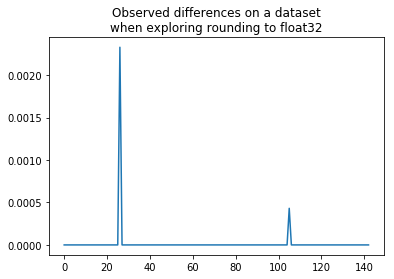

In [19]:
import matplotlib.pyplot as plt
plt.plot(shaked[:, n-1] - shaked[:, 0])
plt.title("Observed differences on a dataset\nwhen exploring rounding to float32");